In [105]:
""" Experiment Settings """
depth_tree = 5
res = []

In [106]:
""" Libraries """
import json
import numpy as np
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt

import nbimporter
from Core import Ranges, nDTree, tree_shape_relation, draw_lines, draw_box, experiment_execution

In [107]:
""" Database Connection """
conn_params = "dbname='trajectory' user='postgres' host='localhost' password='990721' port=5432"
conn = psycopg2.connect(conn_params)
cur = conn.cursor()

In [108]:
""" Overall Size """
sql_overall_size = """
SELECT sum(pg_column_size(geometry)) AS size
FROM traj_{};
""".format(depth_tree)

cur.execute(sql_overall_size)
records = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
res.append(df["size"].tolist()[0])

In [109]:
""" Individual Size """
sql_individual_size = """
SELECT indexing_key, coalesce(sum(pg_column_size(geometry)), 0) AS size
FROM traj_{}
GROUP BY indexing_key;
""".format(depth_tree)

cur.execute(sql_individual_size)
records = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)

In [110]:
""" Empty Ratio """
list_size = df["size"].tolist()
empty_ratio = list_size.count(0) / len(list_size)
res.append(empty_ratio)

""" Global Difference """
global_difference = np.std(list_size)
res.append(global_difference)

In [111]:
def chunk_list(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [112]:
""" Between Group difference """
data = chunk_list(list_size, 8)
group_means = [np.mean(group) for group in data]
between_group_difference = np.std(group_means)
res.append(between_group_difference)

""" Within Group Difference """
within_group_differences = np.mean([np.std(group) for group in data])
res.append(within_group_differences)

In [113]:
cur.close()
conn.close()

In [114]:
print(res)

[152234648, 0.5472412109375, 13034.874398831347, 4632.811799240748, 8690.378527250017]


In [115]:
depth_tree = [0, 1, 2, 3, 4, 5, 6, 7]
res_0 = [62797907, 0.0, 0.0, 0.0, 0.0]
res_1 = [69040414, 0.0, 10942780.089209948, 0.0, 10942780.089209948]
res_2 = [83937058, 0.0, 2130133.981896884, 1690222.9412348284, 860438.3414115076]
res_3 = [103657911, 0.072265625, 396945.9535862942, 338585.121627054, 124128.44717104945]
res_4 = [124169196, 0.3125, 74593.70571933564, 60601.982162728586, 19893.74537628708]
res_5 = [152234648, 0.5472412109375, 13034.874398831347, 4623.45007589106, 8695.579170223646]
res_6 = [208658130, 0.7209625244140625, 2591.4907032082274, 2172.9572143182895, 526.9479724156203]
res_7 = [304977961, 0.8413906097412109, 617.5802239696545, 472.3268754863216, 125.37873500865928]

In [116]:
overall_size = []
empty_ratio = []
global_diff = []
between_diff = []
within_diff = []

all_res = [res_0, res_1, res_2, res_3, res_4, res_5, res_6, res_7]

for res in all_res:
    overall_size.append(res[0])
    empty_ratio.append(res[1])
    global_diff.append(res[2])
    between_diff.append(res[3])
    within_diff.append(res[4])

global_diff = np.array(global_diff) / np.array(overall_size)
between_diff = np.array(between_diff) / np.array(overall_size)
within_diff = np.array(within_diff) / np.array(overall_size)

global_diff = [value / 8 ** (7 - i) for i, value in enumerate(global_diff)]
between_diff = [value / 8 ** (7 - i) for i, value in enumerate(between_diff)]
within_diff = [value / 8 ** (7 - i) for i, value in enumerate(within_diff)]

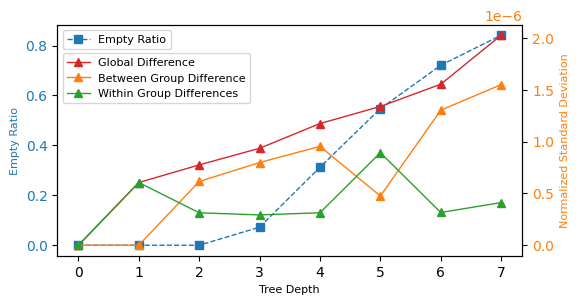

In [119]:
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.set_xlabel('Tree Depth', fontdict={"fontsize": 8})
ax1.set_ylabel('Empty Ratio', color='tab:blue', fontdict={"fontsize": 8})
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.plot(depth_tree, empty_ratio, label='Empty Ratio', color='tab:blue', marker='s', linewidth=1, linestyle='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Normalized Standard Deviation', color='tab:orange', fontdict={"fontsize": 8})
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.plot(depth_tree, global_diff, label='Global Difference', color='tab:red', marker='^', linewidth=1)
ax2.plot(depth_tree, between_diff, label='Between Group Difference', color='tab:orange', marker='^', linewidth=1)
ax2.plot(depth_tree, within_diff, label='Within Group Differences', color='tab:green', marker='^', linewidth=1)

ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 1.0))
ax2.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 0.9))
fig.savefig("figs/distribution.pdf", bbox_inches='tight')
plt.show()

In [123]:
print(depth_tree)
print(['{:.2e}'.format(val) for val in global_diff])
print(['{:.2e}'.format(val) for val in between_diff])
print(['{:.2e}'.format(val) for val in within_diff])
print([round(val, 2) for val in empty_ratio])

[0, 1, 2, 3, 4, 5, 6, 7]
['0.00e+00', '6.05e-07', '7.74e-07', '9.35e-07', '1.17e-06', '1.34e-06', '1.55e-06', '2.02e-06']
['0.00e+00', '0.00e+00', '6.15e-07', '7.97e-07', '9.53e-07', '4.75e-07', '1.30e-06', '1.55e-06']
['0.00e+00', '6.05e-07', '3.13e-07', '2.92e-07', '3.13e-07', '8.92e-07', '3.16e-07', '4.11e-07']
[0.0, 0.0, 0.0, 0.07, 0.31, 0.55, 0.72, 0.84]


In [ ]:
[0, 1, 2, 3, 4, 5, 6, 7]
[0.00e+00& 6.05e-07& 7.74e-07& 9.35e-07& 1.17e-06& 1.34e-06& 1.55e-06& 2.02e-06]
[0.00e+00& 0.00e+00& 6.15e-07& 7.97e-07& 9.53e-07& 4.75e-07& 1.30e-06& 1.55e-06]
[0.00e+00& 6.05e-07& 3.13e-07& 2.92e-07& 3.13e-07& 8.92e-07& 3.16e-07& 4.11e-07]
[0.0& 0.0& 0.0& 0.07& 0.31& 0.55& 0.72& 0.84]